# Trading Dashboard - Data Collection & Analysis
Author: Ondřej Marvan
Course: Python and SQL - Final Project

This notebook collects and analyzes data for 8 investment chatinstruments:
- EUA (European Union Allowance) - EUR
- Crude Oil (WTI) - USD
- Natural Gas - USD
- Gold - USD
- Silver - USD
- Bitcoin - USD
- S&P 500 Index - USD
- NASDAQ 100 Index - USD

Data Period: January 1, 2025 - December 31, 2025 (Daily)

## 1. IMPORT LIBRARIES

In [1]:
# Data manipulation and numerical operations
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Date and time handling
from datetime import datetime, timedelta

# Database connection
import sqlite3

# Mute warning messages for cleaner output
import warnings
warnings.filterwarnings('ignore')

#import yfinance as yf # Iniatially used financial data 

# Set plotting style
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (16, 10) # Chart normalization

## 2. DATA COLLECTION

In [2]:
# Base path for data files
base_path = '/home/ondrej-marvan/Documents/GitHub/OBS_DataScience/OBS_DataScience/Autumn 2025/2400-DS1SQL Python and SQL intro, SQL platforms/Project/data/'

# Define instruments with their properties
INSTRUMENTS = {
    'EUA': {'file': 'EUA_daily.csv', 'name': 'EU Allowance', 'currency': 'EUR', 'type': 'Environmental'},
    'OIL': {'file': 'OIL_daily.csv', 'name': 'Crude Oil WTI', 'currency': 'USD', 'type': 'Energy'},
    'NG': {'file': 'NG_daily.csv', 'name': 'Natural Gas', 'currency': 'USD', 'type': 'Energy'},
    'GOLD': {'file': 'GOLD_daily.csv', 'name': 'Gold', 'currency': 'USD', 'type': 'Precious Metal'},
    'SILVER': {'file': 'SILVER_daily.csv', 'name': 'Silver', 'currency': 'USD', 'type': 'Precious Metal'},
    'BTC': {'file': 'BTC_daily.csv', 'name': 'Bitcoin', 'currency': 'USD', 'type': 'Cryptocurrency'},
    'SPX': {'file': 'S&P500_daily.csv', 'name': 'S&P 500', 'currency': 'USD', 'type': 'Equity Index'},
    'NDX': {'file': 'NASDAQ100_daily.csv', 'name': 'NASDAQ 100', 'currency': 'USD', 'type': 'Equity Index'}
}

def load_csv_data(filepath, symbol_name):
    """Load data from CSV file and standardize format"""
    try:
        # Read CSV file
        df = pd.read_csv(filepath)
        
        # Print actual columns found
        print(f" Columns in {symbol_name}: {list(df.columns)}")
        
        # Exact column names: Date, Price, Open, High, Low, Vol., Change %
        # Creation of standardized dataframe
        result_df = pd.DataFrame()
        
        # Convert date column to datetime
        result_df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
        
        # Convert price columns to numeric values
        result_df['Price'] = pd.to_numeric(df['Price'].astype(str).str.replace(',', ''), errors='coerce') # anything that still cannot be converted will become NaN
        result_df['Open'] = pd.to_numeric(df['Open'].astype(str).str.replace(',', ''), errors='coerce')
        result_df['High'] = pd.to_numeric(df['High'].astype(str).str.replace(',', ''), errors='coerce')
        result_df['Low'] = pd.to_numeric(df['Low'].astype(str).str.replace(',', ''), errors='coerce')
            
            # Take the Price column, treat everything as text, remove thousands separators, convert it to numbers, and if something is garbage, turn it into NaN instead of crashing.
        
        # Volume column - handle Vol. with period and possible K/M/B suffixes
        def parse_volume(x):
            x = str(x).upper().strip().replace(',', '')
            try:
                if x == '-' or x == '' or x == 'NAN':
                    return 0
                if 'B' in x:
                    return float(x.replace('B', '')) * 1000000000
                elif 'M' in x:
                    return float(x.replace('M', '')) * 1000000
                elif 'K' in x:
                    return float(x.replace('K', '')) * 1000
                else:
                    return float(x)
            except:
                return 0
        
        result_df['Vol'] = df['Vol.'].apply(parse_volume)
        
        result_df['Symbol'] = symbol_name
        result_df = result_df.sort_values('Date')
        
        # Fill any ssing OHLC values
        result_df['Open'] = result_df['Open'].fillna(result_df['Price'])
        result_df['High'] = result_df['High'].fillna(result_df['Price'])
        result_df['Low'] = result_df['Low'].fillna(result_df['Price'])
        result_df['Vol'] = result_df['Vol'].fillna(0)
        
        # Ensure High is highest, Low is lowest
        result_df['High'] = result_df[['Open', 'High', 'Low', 'Price']].max(axis=1)
        result_df['Low'] = result_df[['Open', 'High', 'Low', 'Price']].min(axis=1)
        
        valid_records = len(result_df[result_df['Price'].notna()])
        print(f"Loaded {valid_records:,} valid records for {symbol_name}")
        
        return result_df[['Date', 'Symbol', 'Open', 'High', 'Low', 'Price', 'Vol']]
        
    except FileNotFoundError:
        print(f" File not found: {filepath}")
        return pd.DataFrame()
    except KeyError as e:
        print(f" Column not found in {symbol_name}: {str(e)}")
        print(f" Available columns: {list(df.columns)}")
        return pd.DataFrame()
    except Exception as e:
        print(f" Error loading {symbol_name}: {str(e)}")
        print(f" File: {filepath}")
        return pd.DataFrame()

# Load all data files
print("="*80)
print("LOADING DATA FROM CSV FILES")
print("Data Period: 01.01.2025 - 31.12.2025")
print("="*80 + "\n")

all_dataframes = []
failed_loads = []

for symbol, info in INSTRUMENTS.items():
    print(f"Loading {info['name']} ({symbol})...")
    df = load_csv_data(base_path + info['file'], symbol)
    if len(df) > 0:
        all_dataframes.append(df)
    else:
        failed_loads.append(symbol)

# Combine all data
if len(all_dataframes) > 0:
    all_data = pd.concat(all_dataframes, ignore_index=True)
    print(f"\n{'='*80}")
    print(f"✓ SUCCESSFULLY LOADED DATA")
    print(f"{'='*80}")
    print(f"Total records collected: {len(all_data):,}")
    print(f"Instruments loaded: {all_data['Symbol'].nunique()}")
    print(f"Date range: {all_data['Date'].min().date()} to {all_data['Date'].max().date()}")
    
    if failed_loads:
        print(f"\n Failed to load: {', '.join(failed_loads)}")
    
    print(f"{'='*80}\n")
else:
    print("ERROR: No data was loaded.")
    exit()

LOADING DATA FROM CSV FILES
Data Period: 01.01.2025 - 31.12.2025

Loading EU Allowance (EUA)...
 Columns in EUA: ['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']
Loaded 256 valid records for EUA
Loading Crude Oil WTI (OIL)...
 Columns in OIL: ['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']
Loaded 259 valid records for OIL
Loading Natural Gas (NG)...
 Columns in NG: ['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']
Loaded 259 valid records for NG
Loading Gold (GOLD)...
 Columns in GOLD: ['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']
Loaded 259 valid records for GOLD
Loading Silver (SILVER)...
 Columns in SILVER: ['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']
Loaded 258 valid records for SILVER
Loading Bitcoin (BTC)...
 Columns in BTC: ['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']
Loaded 365 valid records for BTC
Loading S&P 500 (SPX)...
 Columns in SPX: ['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change

## 3. DATA CLEANING & PREPROCESSING

In [3]:
def clean_data(df):
    """Clean and preprocess the data"""
    print("Cleaning data...")
    
    initial_count = len(df)
    
    # Remove rows with null dates
    df = df.dropna(subset=['Date'])
    print(f"  - Removed {initial_count - len(df):,} rows with invalid dates")
    
    # Remove duplicates
    initial_count = len(df)
    df = df.drop_duplicates(subset=['Date', 'Symbol'])
    if initial_count - len(df) > 0:
        print(f"  - Removed {initial_count - len(df):,} duplicate records")
    
    # Handle missing values in price data
    missing_before = df['Price'].isnull().sum()
    df = df.dropna(subset=['Price'])
    if missing_before > 0:
        print(f"  - Removed {missing_before:,} rows with missing prices")
    
    # Ensure proper data types
    df['Date'] = pd.to_datetime(df['Date'])
    numeric_cols = ['Open', 'High', 'Low', 'Price', 'Vol']
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Remove any rows with negative or zero prices (data errors)
    price_errors = len(df[df['Price'] <= 0])
    df = df[df['Price'] > 0]
    if price_errors > 0:
        print(f"  - Removed {price_errors:,} rows with invalid prices (<= 0)")
    
    # Sort by symbol and date
    df = df.sort_values(['Symbol', 'Date'])
    
    # Reset index
    df = df.reset_index(drop=True)
    
    print(f"Cleaning complete: {len(df):,} clean records\n")
    return df

all_data = clean_data(all_data)

# Display sample data by instrument
print("="*80)
print("LATEST DATA BY INSTRUMENT")
print("="*80)
print(f"{'Symbol':<8} {'Name':<20} {'Latest Price':<15} {'Currency':<8} {'Date':<12}")
print("-"*80)
for symbol in sorted(all_data['Symbol'].unique()):
    sample = all_data[all_data['Symbol'] == symbol].tail(1)
    if len(sample) > 0:
        latest = sample.iloc[0]
        info = INSTRUMENTS[symbol]
        price_str = f"{latest['Price']:.2f}"
        print(f"{symbol:<8} {info['name']:<20} {price_str:<15} {info['currency']:<8} {latest['Date'].date()}")
print("="*80 + "\n")

Cleaning data...
  - Removed 0 rows with invalid dates
Cleaning complete: 2,156 clean records

LATEST DATA BY INSTRUMENT
Symbol   Name                 Latest Price    Currency Date        
--------------------------------------------------------------------------------
BTC      Bitcoin              87804.50        USD      2025-12-31
EUA      EU Allowance         87.37           EUR      2025-12-31
GOLD     Gold                 4332.10         USD      2025-12-31
NDX      NASDAQ 100           25249.85        USD      2025-12-31
NG       Natural Gas          3.71            USD      2025-12-31
OIL      Crude Oil WTI        57.41           USD      2025-12-31
SILVER   Silver               78.22           USD      2025-12-30
SPX      S&P 500              6845.50         USD      2025-12-31



## 4. TECHNICAL INDICATORS CALCULATION
### Simple Moving Average (SMA)

Simple Moving Average shows the **average price** over selected number of days.
- It is used to smooth price movements
- Helps to see **price trend**
- Short period = faster reaction
- Long period = long-term trend
  
In this project: **20, 50 and 200 days**
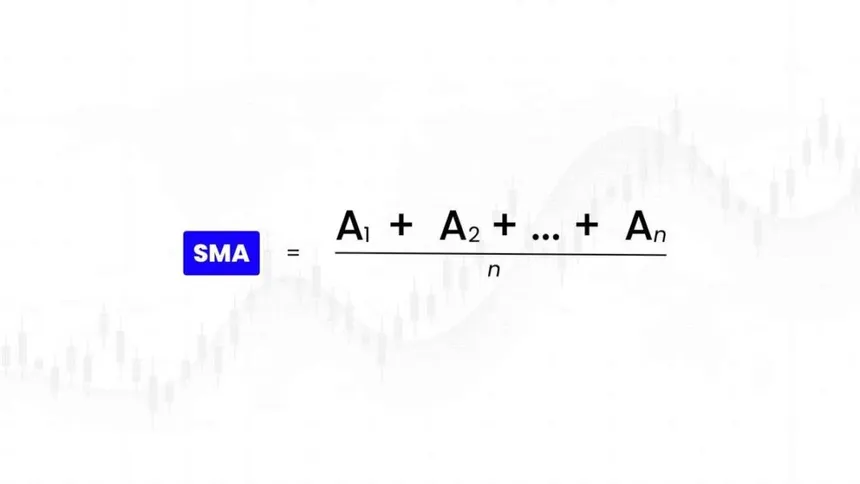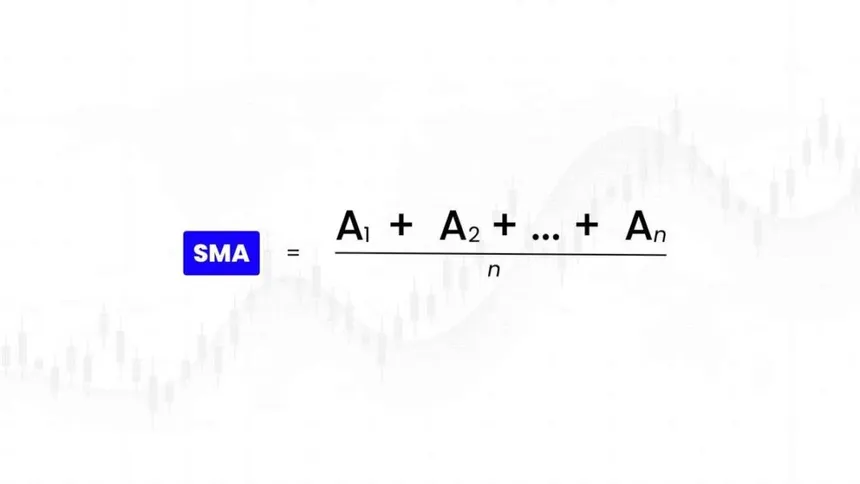

### Bollinger Bands

Bollinger Bands show **price volatility.**

They consist of:
- Middle line – moving average
- Upper band – moving average + standard deviation
- Lower band – moving average − standard deviation

When bands are wide → high volatility
When bands are narrow → low volatility
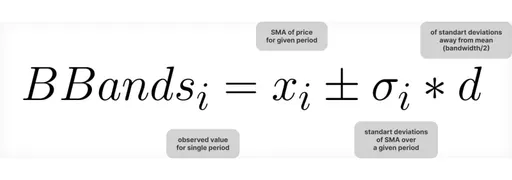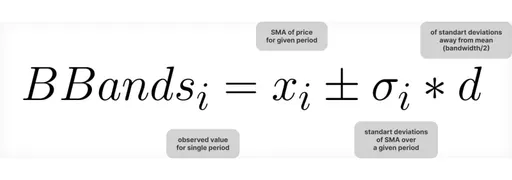

### Relative Strength Index (RSI)

RSI measures **price momentum.**

Values are between **0 and 100**

Compares average gains and losses

Common levels:

RSI > 70 → overbought

RSI < 30 → oversold

In this project: **14-day RSI**
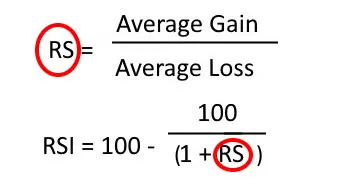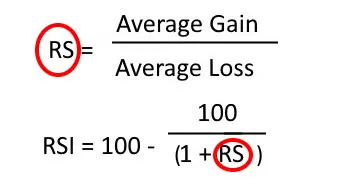

### Daily Returns

Daily returns show **daily price change in percent.**

Used to analyse risk and volatility

Shows how price changes from day to day

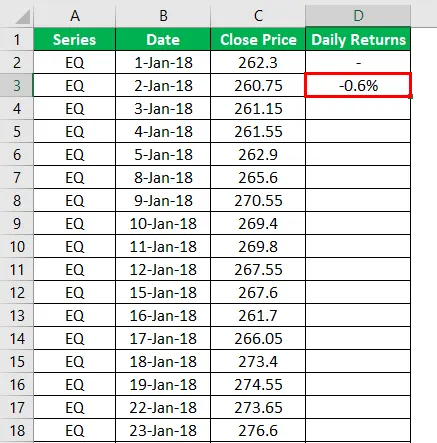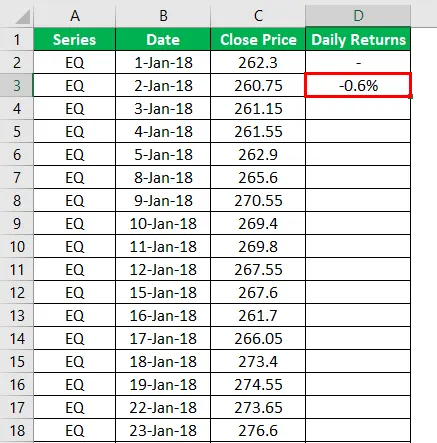

In [4]:
def calculate_sma(df, periods=[20, 50, 200]):
    """Calculate Simple Moving Averages"""
    print(f"Calculating Simple Moving Averages ({periods})...")
    for period in periods:
        df[f'SMA_{period}'] = df.groupby('Symbol')['Price'].transform(
            lambda x: x.rolling(window=period, min_periods=1).mean()
        )
    return df

def calculate_bollinger_bands(df, period=20, std_dev=2):
    """Calculate Bollinger Bands"""
    print(f"Calculating Bollinger Bands (period={period}, std_dev={std_dev})...")
    df['BB_Middle'] = df.groupby('Symbol')['Price'].transform(
        lambda x: x.rolling(window=period, min_periods=1).mean()
    )
    df['BB_Std'] = df.groupby('Symbol')['Price'].transform(
        lambda x: x.rolling(window=period, min_periods=1).std()
    )
    df['BB_Upper'] = df['BB_Middle'] + (std_dev * df['BB_Std'])
    df['BB_Lower'] = df['BB_Middle'] - (std_dev * df['BB_Std'])
    return df

def calculate_rsi(df, period=14):
    """Calculate Relative Strength Index"""
    print(f"Calculating RSI (period={period})...")
    def rsi_calc(prices):
        deltas = prices.diff()
        gain = deltas.where(deltas > 0, 0).rolling(window=period, min_periods=1).mean()
        loss = -deltas.where(deltas < 0, 0).rolling(window=period, min_periods=1).mean()
        rs = gain / loss
        return 100 - (100 / (1 + rs))
    
    df['RSI'] = df.groupby('Symbol')['Price'].transform(rsi_calc)
    return df

def calculate_daily_returns(df):
    """Calculate daily returns"""
    print("Calculating daily returns...")
    df['Daily_Return'] = df.groupby('Symbol')['Price'].pct_change() * 100
    return df

# Apply technical indicators
print("\n" + "="*80)
print("CALCULATING TECHNICAL INDICATORS")
print("="*80 + "\n")

all_data = calculate_sma(all_data, [20, 50, 200])
all_data = calculate_bollinger_bands(all_data)
all_data = calculate_rsi(all_data)
all_data = calculate_daily_returns(all_data)

print("All calculated")


CALCULATING TECHNICAL INDICATORS

Calculating Simple Moving Averages ([20, 50, 200])...
Calculating Bollinger Bands (period=20, std_dev=2)...
Calculating RSI (period=14)...
Calculating daily returns...
All calculated


## 5. TRADING STRATEGY BACKTESTING

In [5]:
def backtest_rsi_strategy(df, buy_threshold=30, sell_threshold=70):
    """
    Backtest RSI-based trading strategy
    Buy when RSI < buy_threshold
    Sell when RSI > sell_threshold
    """
    df = df.copy()
    df['Position'] = 0
    df['Trade_Signal'] = ''
    df['Trade_Price'] = np.nan
    df['Trade_PnL'] = 0.0
    df['Cumulative_PnL'] = 0.0
    
    position = 0
    entry_price = 0
    trades = []
    
    for idx in range(1, len(df)):
        current_rsi = df.iloc[idx]['RSI']
        current_price = df.iloc[idx]['Price']
        current_date = df.iloc[idx]['Date']
        
        # Buy signal
        if current_rsi < buy_threshold and position == 0:
            position = 1
            entry_price = current_price
            df.loc[df.index[idx], 'Position'] = 1
            df.loc[df.index[idx], 'Trade_Signal'] = 'BUY'
            df.loc[df.index[idx], 'Trade_Price'] = current_price
            trades.append({
                'Date': current_date,
                'Type': 'BUY',
                'Price': current_price,
                'Indicator': current_rsi
            })
        
        # Sell signal
        elif current_rsi > sell_threshold and position == 1:
            pnl = current_price - entry_price
            pnl_pct = (pnl / entry_price) * 100
            position = 0
            df.loc[df.index[idx], 'Position'] = 0
            df.loc[df.index[idx], 'Trade_Signal'] = 'SELL'
            df.loc[df.index[idx], 'Trade_Price'] = current_price
            df.loc[df.index[idx], 'Trade_PnL'] = pnl_pct
            trades.append({
                'Date': current_date,
                'Type': 'SELL',
                'Price': current_price,
                'Indicator': current_rsi,
                'PnL': pnl,
                'PnL_pct': pnl_pct
            })
        
        elif position == 1:
            df.loc[df.index[idx], 'Position'] = 1
    
    df['Cumulative_PnL'] = df['Trade_PnL'].cumsum()
    return df, pd.DataFrame(trades)

def backtest_ma_crossover_strategy(df, fast_period=20, slow_period=50):
    """
    Backtest Moving Average Crossover strategy
    Buy when fast MA crosses above slow MA (Golden Cross)
    Sell when fast MA crosses below slow MA (Death Cross)
    """
    df = df.copy()
    df['Position'] = 0
    df['Trade_Signal'] = ''
    df['Trade_Price'] = np.nan
    df['Trade_PnL'] = 0.0
    df['Cumulative_PnL'] = 0.0
    
    # Use existing SMAs
    fast_ma_col = f'SMA_{fast_period}'
    slow_ma_col = f'SMA_{slow_period}'
    
    position = 0
    entry_price = 0
    trades = []
    
    for idx in range(1, len(df)):
        current_price = df.iloc[idx]['Price']
        current_date = df.iloc[idx]['Date']
        fast_ma = df.iloc[idx][fast_ma_col]
        slow_ma = df.iloc[idx][slow_ma_col]
        prev_fast_ma = df.iloc[idx-1][fast_ma_col]
        prev_slow_ma = df.iloc[idx-1][slow_ma_col]
        
        # Golden Cross - Buy signal
        if prev_fast_ma <= prev_slow_ma and fast_ma > slow_ma and position == 0:
            position = 1
            entry_price = current_price
            df.loc[df.index[idx], 'Position'] = 1
            df.loc[df.index[idx], 'Trade_Signal'] = 'BUY'
            df.loc[df.index[idx], 'Trade_Price'] = current_price
            trades.append({
                'Date': current_date,
                'Type': 'BUY',
                'Price': current_price,
                'Indicator': fast_ma - slow_ma
            })
        
        # Death Cross - Sell signal
        elif prev_fast_ma >= prev_slow_ma and fast_ma < slow_ma and position == 1:
            pnl = current_price - entry_price
            pnl_pct = (pnl / entry_price) * 100
            position = 0
            df.loc[df.index[idx], 'Position'] = 0
            df.loc[df.index[idx], 'Trade_Signal'] = 'SELL'
            df.loc[df.index[idx], 'Trade_Price'] = current_price
            df.loc[df.index[idx], 'Trade_PnL'] = pnl_pct
            trades.append({
                'Date': current_date,
                'Type': 'SELL',
                'Price': current_price,
                'Indicator': fast_ma - slow_ma,
                'PnL': pnl,
                'PnL_pct': pnl_pct
            })
        
        elif position == 1:
            df.loc[df.index[idx], 'Position'] = 1
    
    df['Cumulative_PnL'] = df['Trade_PnL'].cumsum()
    return df, pd.DataFrame(trades)

def backtest_bollinger_bands_strategy(df):
    """
    Backtest Bollinger Bands strategy
    Buy when price touches or goes below lower band
    Sell when price touches or goes above upper band
    """
    df = df.copy()
    df['Position'] = 0
    df['Trade_Signal'] = ''
    df['Trade_Price'] = np.nan
    df['Trade_PnL'] = 0.0
    df['Cumulative_PnL'] = 0.0
    
    position = 0
    entry_price = 0
    trades = []
    
    for idx in range(1, len(df)):
        current_price = df.iloc[idx]['Price']
        current_date = df.iloc[idx]['Date']
        bb_upper = df.iloc[idx]['BB_Upper']
        bb_lower = df.iloc[idx]['BB_Lower']
        bb_middle = df.iloc[idx]['BB_Middle']
        
        # Buy signal - price at or below lower band
        if current_price <= bb_lower and position == 0:
            position = 1
            entry_price = current_price
            df.loc[df.index[idx], 'Position'] = 1
            df.loc[df.index[idx], 'Trade_Signal'] = 'BUY'
            df.loc[df.index[idx], 'Trade_Price'] = current_price
            trades.append({
                'Date': current_date,
                'Type': 'BUY',
                'Price': current_price,
                'Indicator': (current_price - bb_middle) / bb_middle * 100
            })
        
        # Sell signal - price at or above upper band
        elif current_price >= bb_upper and position == 1:
            pnl = current_price - entry_price
            pnl_pct = (pnl / entry_price) * 100
            position = 0
            df.loc[df.index[idx], 'Position'] = 0
            df.loc[df.index[idx], 'Trade_Signal'] = 'SELL'
            df.loc[df.index[idx], 'Trade_Price'] = current_price
            df.loc[df.index[idx], 'Trade_PnL'] = pnl_pct
            trades.append({
                'Date': current_date,
                'Type': 'SELL',
                'Price': current_price,
                'Indicator': (current_price - bb_middle) / bb_middle * 100,
                'PnL': pnl,
                'PnL_pct': pnl_pct
            })
        
        elif position == 1:
            df.loc[df.index[idx], 'Position'] = 1
    
    df['Cumulative_PnL'] = df['Trade_PnL'].cumsum()
    return df, pd.DataFrame(trades)

def calculate_strategy_metrics(df, trades_df):
    """Calculate strategy performance metrics"""
    if len(trades_df) == 0:
        return {}
    
    sell_trades = trades_df[trades_df['Type'] == 'SELL']
    
    if len(sell_trades) == 0:
        return {'Total_Trades': 0, 'Win_Rate': 0, 'Avg_PnL': 0}
    
    total_trades = len(sell_trades)
    winning_trades = len(sell_trades[sell_trades['PnL'] > 0])
    win_rate = (winning_trades / total_trades * 100) if total_trades > 0 else 0
    avg_pnl = sell_trades['PnL_pct'].mean()
    total_pnl = sell_trades['PnL_pct'].sum()
    max_gain = sell_trades['PnL_pct'].max() if len(sell_trades) > 0 else 0
    max_loss = sell_trades['PnL_pct'].min() if len(sell_trades) > 0 else 0
    
    return {
        'Total_Trades': total_trades,
        'Winning_Trades': winning_trades,
        'Losing_Trades': total_trades - winning_trades,
        'Win_Rate': win_rate,
        'Avg_PnL_pct': avg_pnl,
        'Total_PnL_pct': total_pnl,
        'Max_Gain_pct': max_gain,
        'Max_Loss_pct': max_loss
    }

# Store all strategy results
all_strategy_results = {
    'RSI': {},
    'MA_Crossover': {},
    'Bollinger_Bands': {}
}

all_trades_by_strategy = {
    'RSI': [],
    'MA_Crossover': [],
    'Bollinger_Bands': []
}

for symbol in sorted(all_data['Symbol'].unique()):
    print(f"\n{'='*60}")
    print(f"BACKTESTING {symbol}")
    print('='*60)
    
    symbol_data = all_data[all_data['Symbol'] == symbol].copy()
    
    # Strategy 1: RSI
    print(f"\n1. RSI Strategy (Buy<30, Sell>70):")
    backtested_data, trades = backtest_rsi_strategy(symbol_data, buy_threshold=30, sell_threshold=70)
    metrics = calculate_strategy_metrics(backtested_data, trades)
    
    if metrics.get('Total_Trades', 0) > 0:
        print(f"   Trades: {metrics['Total_Trades']}, Win Rate: {metrics['Win_Rate']:.1f}%, "
              f"Avg P&L: {metrics['Avg_PnL_pct']:.2f}%, Total P&L: {metrics['Total_PnL_pct']:.2f}%")
        all_strategy_results['RSI'][symbol] = {
            'data': backtested_data,
            'trades': trades,
            'metrics': metrics
        }
        trades['Symbol'] = symbol
        trades['Strategy'] = 'RSI'
        all_trades_by_strategy['RSI'].append(trades)
    else:
        print(f"   No trades generated")
    
    # Strategy 2: MA Crossover
    print(f"\n2. MA Crossover Strategy (20/50):")
    backtested_data, trades = backtest_ma_crossover_strategy(symbol_data, fast_period=20, slow_period=50)
    metrics = calculate_strategy_metrics(backtested_data, trades)
    
    if metrics.get('Total_Trades', 0) > 0:
        print(f"   Trades: {metrics['Total_Trades']}, Win Rate: {metrics['Win_Rate']:.1f}%, "
              f"Avg P&L: {metrics['Avg_PnL_pct']:.2f}%, Total P&L: {metrics['Total_PnL_pct']:.2f}%")
        all_strategy_results['MA_Crossover'][symbol] = {
            'data': backtested_data,
            'trades': trades,
            'metrics': metrics
        }
        trades['Symbol'] = symbol
        trades['Strategy'] = 'MA_Crossover'
        all_trades_by_strategy['MA_Crossover'].append(trades)
    else:
        print(f"   No trades generated")
    
    # Strategy 3: Bollinger Bands
    print(f"\n3. Bollinger Bands Strategy:")
    backtested_data, trades = backtest_bollinger_bands_strategy(symbol_data)
    metrics = calculate_strategy_metrics(backtested_data, trades)
    
    if metrics.get('Total_Trades', 0) > 0:
        print(f"   Trades: {metrics['Total_Trades']}, Win Rate: {metrics['Win_Rate']:.1f}%, "
              f"Avg P&L: {metrics['Avg_PnL_pct']:.2f}%, Total P&L: {metrics['Total_PnL_pct']:.2f}%")
        all_strategy_results['Bollinger_Bands'][symbol] = {
            'data': backtested_data,
            'trades': trades,
            'metrics': metrics
        }
        trades['Symbol'] = symbol
        trades['Strategy'] = 'Bollinger_Bands'
        all_trades_by_strategy['Bollinger_Bands'].append(trades)
    else:
        print(f"   No trades generated")

# Combine trades for each strategy
combined_trades = {}
for strategy_name, trades_list in all_trades_by_strategy.items():
    if trades_list:
        combined_trades[strategy_name] = pd.concat(trades_list, ignore_index=True)
    else:
        combined_trades[strategy_name] = pd.DataFrame()


print("Done")



BACKTESTING BTC

1. RSI Strategy (Buy<30, Sell>70):
   Trades: 4, Win Rate: 75.0%, Avg P&L: 5.30%, Total P&L: 21.20%

2. MA Crossover Strategy (20/50):
   Trades: 4, Win Rate: 75.0%, Avg P&L: 2.16%, Total P&L: 8.65%

3. Bollinger Bands Strategy:
   Trades: 5, Win Rate: 80.0%, Avg P&L: 6.46%, Total P&L: 32.31%

BACKTESTING EUA

1. RSI Strategy (Buy<30, Sell>70):
   Trades: 3, Win Rate: 66.7%, Avg P&L: 4.60%, Total P&L: 13.79%

2. MA Crossover Strategy (20/50):
   Trades: 2, Win Rate: 0.0%, Avg P&L: -7.92%, Total P&L: -15.85%

3. Bollinger Bands Strategy:
   Trades: 2, Win Rate: 50.0%, Avg P&L: -1.00%, Total P&L: -2.01%

BACKTESTING GOLD

1. RSI Strategy (Buy<30, Sell>70):
   Trades: 2, Win Rate: 100.0%, Avg P&L: 4.04%, Total P&L: 8.09%

2. MA Crossover Strategy (20/50):
   Trades: 1, Win Rate: 100.0%, Avg P&L: 18.46%, Total P&L: 18.46%

3. Bollinger Bands Strategy:
   Trades: 1, Win Rate: 100.0%, Avg P&L: 5.33%, Total P&L: 5.33%

BACKTESTING NDX

1. RSI Strategy (Buy<30, Sell>70):
   T

## 6. SAVE TO SQL DATABASE

In [6]:
def save_to_database(df, db_name='commodities_trading.db'):
    """Save data to SQLite database"""
    print("="*80)
    print("SAVING DATA TO DATABASE")
    print("="*80 + "\n")
    
    conn = sqlite3.connect(db_name)
    
    # Main prices table
    print("Creating 'prices' table...")
    df.to_sql('prices', conn, if_exists='replace', index=False)
    print(f"  ✓ Saved {len(df):,} records to 'prices' table")
    
    # Create instrument metadata table
    print("\nCreating 'instruments' table...")
    instruments_df = pd.DataFrame([
        {'Symbol': k, 'Name': v['name'], 'Currency': v['currency'], 'Type': v['type']}
        for k, v in INSTRUMENTS.items() if k in df['Symbol'].unique()
    ])
    instruments_df.to_sql('instruments', conn, if_exists='replace', index=False)
    print(f"  ✓ Saved metadata for {len(instruments_df)} instruments")
    
    # Create aggregated statistics table
    print("\nCreating 'statistics' table...")
    stats_df = df.groupby('Symbol').agg({
        'Price': ['mean', 'std', 'min', 'max'],
        'Vol': 'sum',
        'Daily_Return': ['mean', 'std']
    }).reset_index()
    stats_df.columns = ['Symbol', 'Avg_Price', 'Price_Std', 'Min_Price', 'Max_Price', 
                        'Total_Volume', 'Avg_Return', 'Return_Volatility']
    
    # Merge with instrument info
    stats_df = stats_df.merge(instruments_df[['Symbol', 'Currency', 'Type']], on='Symbol', how='left')
    stats_df.to_sql('statistics', conn, if_exists='replace', index=False)
    print(f"  ✓ Saved statistics for {len(stats_df)} instruments")
    
    # Save backtest results for all strategies
    print("\nCreating 'backtest_results' table...")
    backtest_summary = []
    
    for strategy_name in ['RSI', 'MA_Crossover', 'Bollinger_Bands']:
        for symbol, results in all_strategy_results[strategy_name].items():
            metrics = results['metrics']
            backtest_summary.append({
                'Symbol': symbol,
                'Strategy': strategy_name,
                'Total_Trades': metrics.get('Total_Trades', 0),
                'Win_Rate': metrics.get('Win_Rate', 0),
                'Total_PnL_pct': metrics.get('Total_PnL_pct', 0),
                'Avg_PnL_pct': metrics.get('Avg_PnL_pct', 0),
                'Max_Gain_pct': metrics.get('Max_Gain_pct', 0),
                'Max_Loss_pct': metrics.get('Max_Loss_pct', 0)
            })
    
    if backtest_summary:
        backtest_df = pd.DataFrame(backtest_summary)
        backtest_df.to_sql('backtest_results', conn, if_exists='replace', index=False)
        print(f"  ✓ Saved backtest results for {len(backtest_df)} strategy-instrument combinations")
    
    # Save all trades from all strategies
    print("\nCreating 'backtest_trades' table...")
    all_trades_combined = []
    for strategy_name, trades_df in combined_trades.items():
        if len(trades_df) > 0:
            all_trades_combined.append(trades_df)
    
    if all_trades_combined:
        all_trades_final = pd.concat(all_trades_combined, ignore_index=True)
        all_trades_final.to_sql('backtest_trades', conn, if_exists='replace', index=False)
        print(f"  ✓ Saved {len(all_trades_final)} backtest trades from all strategies")
    
    # Create users table for login
    print("\nCreating 'users' table...")
    users_df = pd.DataFrame({
        'username': ['admin', 'trader1', 'demo_user'],
        'password': ['admin123', 'trader123', 'demo123'],
        'role': ['admin', 'trader', 'demo']
    })
    users_df.to_sql('users', conn, if_exists='replace', index=False)
    print(f"  ✓ Created {len(users_df)} user accounts")
    
    # Create orders table with extended fields
    print("\nCreating 'orders' table...")
    conn.execute('''
        CREATE TABLE IF NOT EXISTS orders (
            order_id INTEGER PRIMARY KEY AUTOINCREMENT,
            timestamp DATETIME,
            username TEXT,
            symbol TEXT,
            order_type TEXT,
            quantity REAL,
            price REAL,
            total_value REAL,
            stop_loss REAL,
            take_profit REAL,
            order_status TEXT DEFAULT 'Pending',
            execution_date DATETIME,
            exit_price REAL,
            pnl REAL,
            pnl_pct REAL,
            notes TEXT
        )
    ''')
    print("  ✓ Orders table created with limit/stop-loss support")
    
    conn.commit()
    conn.close()
    print(f"\n{'='*80}")
    print(f"✓ All data saved to '{db_name}'")
    print(f"{'='*80}\n")

save_to_database(all_data)

SAVING DATA TO DATABASE

Creating 'prices' table...
  ✓ Saved 2,156 records to 'prices' table

Creating 'instruments' table...
  ✓ Saved metadata for 8 instruments

Creating 'statistics' table...
  ✓ Saved statistics for 8 instruments

Creating 'backtest_results' table...
  ✓ Saved backtest results for 24 strategy-instrument combinations

Creating 'backtest_trades' table...
  ✓ Saved 125 backtest trades from all strategies

Creating 'users' table...
  ✓ Created 3 user accounts

Creating 'orders' table...
  ✓ Orders table created with limit/stop-loss support

✓ All data saved to 'commodities_trading.db'



## 7. EXPLORATORY DATA ANALYSIS & VISUALIZATIONS

In [7]:
print("\n" + "="*80)
print("EXPLORATORY DATA ANALYSIS")
print("="*80)

# Summary statistics by instrument
print("\n1. SUMMARY STATISTICS BY INSTRUMENT:")
print("-" * 80)
for symbol in sorted(all_data['Symbol'].unique()):
    symbol_data = all_data[all_data['Symbol'] == symbol]
    info = INSTRUMENTS[symbol]
    print(f"\n{symbol} ({info['name']}) - {info['currency']}:")
    print(f"  Records: {len(symbol_data):,}")
    print(f"  Price Range: {symbol_data['Price'].min():.2f} - {symbol_data['Price'].max():.2f}")
    print(f"  Avg Price: {symbol_data['Price'].mean():.2f}")
    print(f"  Avg Daily Return: {symbol_data['Daily_Return'].mean():.3f}%")
    print(f"  Volatility (Std Dev): {symbol_data['Daily_Return'].std():.3f}%")
    print(f"  Current RSI: {symbol_data['RSI'].iloc[-1]:.1f}")

# Recent market structure
print("\n2. CURRENT MARKET STATUS:")
print("-" * 80)
print(f"{'Symbol':<8} {'Name':<20} {'Price':<12} {'Currency':<8} {'RSI':<8}")
print("-" * 80)
for symbol in sorted(all_data['Symbol'].unique()):
    latest = all_data[all_data['Symbol'] == symbol].tail(1).iloc[0]
    info = INSTRUMENTS[symbol]
    print(f"{symbol:<8} {info['name']:<20} {latest['Price']:<12.2f} {info['currency']:<8} "
          f"{latest['RSI']:<8.1f}")

# Data availability
print("\n3. DATA AVAILABILITY BY INSTRUMENT:")
print("-" * 80)
print(f"{'Symbol':<8} {'Name':<20} {'Start Date':<12} {'End Date':<12} {'Records':<10} {'Trading Days':<12}")
print("-" * 80)
for symbol in sorted(all_data['Symbol'].unique()):
    symbol_data = all_data[all_data['Symbol'] == symbol]
    info = INSTRUMENTS[symbol]
    trading_days = len(symbol_data)
    print(f"{symbol:<8} {info['name']:<20} {symbol_data['Date'].min().date()} "
          f"{symbol_data['Date'].max().date()} {len(symbol_data):<10,} {trading_days:<12,}")

print("\n" + "="*80)
print("GENERATING VISUALIZATIONS (10+ charts)")
print("="*80 + "\n")

# Get symbols list
symbols_list = sorted(all_data['Symbol'].unique())

# Visualization 1: Price Trends (2x4 grid)
print("1. Creating price trends chart...")
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()
for i, symbol in enumerate(symbols_list):
    data = all_data[all_data['Symbol'] == symbol]
    if len(data) > 0:
        axes[i].plot(data['Date'], data['Price'], label='Price', linewidth=2, color='#2E86AB')
        axes[i].plot(data['Date'], data['SMA_20'], label='SMA 20', alpha=0.7, color='#A23B72', linestyle='--')
        axes[i].plot(data['Date'], data['SMA_50'], label='SMA 50', alpha=0.7, color='#F18F01', linestyle='--')
        info = INSTRUMENTS[symbol]
        axes[i].set_title(f'{symbol} - {info["name"]} ({info["currency"]})', fontsize=11, fontweight='bold')
        axes[i].set_xlabel('Date', fontsize=9)
        axes[i].set_ylabel(f'Price ({info["currency"]})', fontsize=9)
        axes[i].legend(fontsize=8, loc='best')
        axes[i].tick_params(axis='x', rotation=45, labelsize=8)
        axes[i].grid(True, alpha=0.3)
plt.suptitle('Price Trends with Moving Averages (2025)', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('price_trends.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved: price_trends.png")
plt.close()

# Visualization 2: Bollinger Bands (2x4 grid)
print("2. Creating Bollinger Bands chart...")
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()
for i, symbol in enumerate(symbols_list):
    data = all_data[all_data['Symbol'] == symbol]
    if len(data) > 0:
        axes[i].plot(data['Date'], data['Price'], label='Price', linewidth=2, color='black')
        axes[i].plot(data['Date'], data['BB_Upper'], label='Upper Band', linestyle='--', alpha=0.7, color='red')
        axes[i].plot(data['Date'], data['BB_Middle'], label='Middle', alpha=0.7, color='blue')
        axes[i].plot(data['Date'], data['BB_Lower'], label='Lower Band', linestyle='--', alpha=0.7, color='green')
        axes[i].fill_between(data['Date'], data['BB_Lower'], data['BB_Upper'], alpha=0.15, color='lightblue')
        info = INSTRUMENTS[symbol]
        axes[i].set_title(f'{symbol} - Bollinger Bands', fontsize=11, fontweight='bold')
        axes[i].set_xlabel('Date', fontsize=9)
        axes[i].set_ylabel(f'Price ({info["currency"]})', fontsize=9)
        axes[i].legend(fontsize=8, loc='best')
        axes[i].tick_params(axis='x', rotation=45, labelsize=8)
        axes[i].grid(True, alpha=0.3)
plt.suptitle('Bollinger Bands Analysis (2025)', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('bollinger_bands.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved: bollinger_bands.png")
plt.close()

# Visualization 3: RSI Comparison (2x4 grid)
print("3. Creating RSI analysis chart...")
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()
for i, symbol in enumerate(symbols_list):
    data = all_data[all_data['Symbol'] == symbol]
    if len(data) > 0:
        axes[i].plot(data['Date'], data['RSI'], linewidth=2, color='purple')
        axes[i].axhline(y=70, color='r', linestyle='--', label='Overbought (70)', alpha=0.7, linewidth=1.5)
        axes[i].axhline(y=30, color='g', linestyle='--', label='Oversold (30)', alpha=0.7, linewidth=1.5)
        axes[i].fill_between(data['Date'], 30, 70, alpha=0.1, color='gray')
        axes[i].set_title(f'{symbol} - RSI', fontsize=11, fontweight='bold')
        axes[i].set_xlabel('Date', fontsize=9)
        axes[i].set_ylabel('RSI', fontsize=9)
        axes[i].legend(fontsize=8, loc='best')
        axes[i].set_ylim(0, 100)
        axes[i].tick_params(axis='x', rotation=45, labelsize=8)
        axes[i].grid(True, alpha=0.3)
plt.suptitle('RSI (Relative Strength Index) Analysis (2025)', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('rsi_analysis.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved: rsi_analysis.png")
plt.close()

# Visualization 4: Daily Returns Distribution (2x4 grid)
print("4. Creating returns distribution chart...")
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()
for i, symbol in enumerate(symbols_list):
    data = all_data[all_data['Symbol'] == symbol]['Daily_Return'].dropna()
    if len(data) > 0:
        axes[i].hist(data, bins=40, edgecolor='black', alpha=0.7, color='skyblue')
        axes[i].axvline(data.mean(), color='r', linestyle='--', linewidth=2, label=f'Mean: {data.mean():.2f}%')
        axes[i].axvline(data.median(), color='g', linestyle='--', linewidth=2, label=f'Median: {data.median():.2f}%')
        axes[i].axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.3)
        axes[i].set_title(f'{symbol} - Daily Returns', fontsize=11, fontweight='bold')
        axes[i].set_xlabel('Daily Return (%)', fontsize=9)
        axes[i].set_ylabel('Frequency', fontsize=9)
        axes[i].legend(fontsize=8, loc='best')
        axes[i].grid(True, alpha=0.3, axis='y')
plt.suptitle('Daily Returns Distribution (2025)', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('returns_distribution.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved: returns_distribution.png")
plt.close()

# Visualization 5: Correlation Heatmap
print("5. Creating correlation matrix...")
plt.figure(figsize=(12, 10))
pivot_data = all_data.pivot_table(values='Price', index='Date', columns='Symbol')
correlation = pivot_data.corr()
mask = np.triu(np.ones_like(correlation, dtype=bool))
sns.heatmap(correlation, mask=mask, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            fmt='.2f', annot_kws={'size': 11}, vmin=-1, vmax=1)
plt.title('Price Correlation Matrix - All Instruments (2025)', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved: correlation_matrix.png")
plt.close()

# Visualization 6: Strategy Comparison - All 3 Strategies (2x4 grid)
print("6. Creating multi-strategy backtest chart...")
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, symbol in enumerate(symbols_list):
    # Plot price
    symbol_data = all_data[all_data['Symbol'] == symbol]
    axes[i].plot(symbol_data['Date'], symbol_data['Price'], 
                linewidth=1, color='black', alpha=0.4, label='Price')
    
    # Plot signals for each strategy
    colors = {'RSI': 'blue', 'MA_Crossover': 'purple', 'Bollinger_Bands': 'orange'}
    markers_buy = {' RSI': '^', 'MA_Crossover': 'D', 'Bollinger_Bands': 's'}
    markers_sell = {'RSI': 'v', 'MA_Crossover': 'D', 'Bollinger_Bands': 's'}
    
    for strategy_name, strategy_results in all_strategy_results.items():
        if symbol in strategy_results:
            data = strategy_results[symbol]['data']
            
            # Buy signals
            buy_signals = data[data['Trade_Signal'] == 'BUY']
            if len(buy_signals) > 0:
                axes[i].scatter(buy_signals['Date'], buy_signals['Trade_Price'], 
                              color=colors[strategy_name], marker='^', s=60, 
                              alpha=0.7, edgecolors='black', linewidth=0.5,
                              label=f'{strategy_name} Buy')
            
            # Sell signals
            sell_signals = data[data['Trade_Signal'] == 'SELL']
            if len(sell_signals) > 0:
                axes[i].scatter(sell_signals['Date'], sell_signals['Trade_Price'], 
                              color=colors[strategy_name], marker='v', s=60, 
                              alpha=0.7, edgecolors='black', linewidth=0.5,
                              label=f'{strategy_name} Sell')
    
    axes[i].set_title(f'{symbol} - All Strategies', fontsize=10, fontweight='bold')
    axes[i].set_xlabel('Date', fontsize=8)
    axes[i].set_ylabel('Price', fontsize=8)
    axes[i].tick_params(axis='x', rotation=45, labelsize=7)
    axes[i].grid(True, alpha=0.3)
    axes[i].legend(fontsize=6, loc='best', ncol=2)

plt.suptitle('Strategy Comparison: RSI vs MA Crossover vs Bollinger Bands', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('strategy_comparison.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved: strategy_comparison.png")
plt.close()

# Visualization 7: Volume Analysis (2x4 grid)
print("7. Creating volume analysis chart...")
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()
for i, symbol in enumerate(symbols_list):
    data = all_data[all_data['Symbol'] == symbol]
    if len(data) > 0 and data['Vol'].sum() > 0:
        colors = ['red' if ret < 0 else 'green' for ret in data['Daily_Return'].fillna(0)]
        axes[i].bar(data['Date'], data['Vol'], alpha=0.6, color=colors, width=1)
        axes[i].set_title(f'{symbol} - Trading Volume', fontsize=11, fontweight='bold')
        axes[i].set_xlabel('Date', fontsize=9)
        axes[i].set_ylabel('Volume', fontsize=9)
        axes[i].tick_params(axis='x', rotation=45, labelsize=8)
        axes[i].grid(True, alpha=0.3, axis='y')
        # Format y-axis for large numbers
        axes[i].ticklabel_format(style='plain', axis='y')
    else:
        axes[i].text(0.5, 0.5, f'No volume data\navailable for {symbol}', 
                    ha='center', va='center', transform=axes[i].transAxes, fontsize=10)
        axes[i].set_title(f'{symbol} - Trading Volume', fontsize=11, fontweight='bold')
plt.suptitle('Trading Volume Analysis (2025)', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('volume_analysis.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved: volume_analysis.png")
plt.close()

# Visualization 8: Cumulative Returns
print("8. Creating cumulative returns chart...")
plt.figure(figsize=(16, 9))
for symbol in symbols_list:
    data = all_data[all_data['Symbol'] == symbol].copy()
    if len(data) > 0:
        data['Cumulative_Return'] = (1 + data['Daily_Return']/100).cumprod() - 1
        plt.plot(data['Date'], data['Cumulative_Return'] * 100, label=symbol, linewidth=2.5)

plt.title('Cumulative Returns Comparison - All Instruments (2025)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Return (%)', fontsize=12)
plt.legend(fontsize=11, loc='best', ncol=2)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)
plt.tight_layout()
plt.savefig('cumulative_returns.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved: cumulative_returns.png")
plt.close()

# Visualization 9: Risk-Return Scatter
print("9. Creating risk-return profile chart...")
plt.figure(figsize=(12, 9))
risk_return = all_data.groupby('Symbol').agg({
    'Daily_Return': ['mean', 'std']
}).reset_index()
risk_return.columns = ['Symbol', 'Avg_Return', 'Volatility']

# Define colors for each instrument type
colors_map = {
    'EUA': '#9B59B6', 'OIL': '#E74C3C', 'NG': '#3498DB', 
    'GOLD': '#F39C12', 'SILVER': '#95A5A6', 'BTC': '#E67E22',
    'SPX': '#27AE60', 'NDX': '#16A085'
}

for _, row in risk_return.iterrows():
    color = colors_map.get(row['Symbol'], 'gray')
    plt.scatter(row['Volatility'], row['Avg_Return'], s=400, alpha=0.7, color=color, edgecolors='black', linewidth=2)
    plt.annotate(row['Symbol'], (row['Volatility'], row['Avg_Return']), 
                fontsize=12, ha='center', va='center', fontweight='bold', color='white')

plt.axhline(y=0, color='black', linestyle='--', linewidth=1.5, alpha=0.5)
plt.axvline(x=risk_return['Volatility'].mean(), color='gray', linestyle='--', linewidth=1, alpha=0.3, label='Avg Volatility')
plt.title('Risk-Return Profile - All Instruments (2025)', fontsize=16, fontweight='bold')
plt.xlabel('Volatility (Std Dev of Daily Returns %)', fontsize=12)
plt.ylabel('Average Daily Return (%)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig('risk_return.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved: risk_return.png")
plt.close()

# Visualization 10: Price Performance Comparison (Normalized)
print("10. Creating normalized performance chart...")
plt.figure(figsize=(16, 9))
for symbol in symbols_list:
    data = all_data[all_data['Symbol'] == symbol].copy()
    if len(data) > 0 and data['Price'].iloc[0] > 0:
        data['Normalized_Price'] = (data['Price'] / data['Price'].iloc[0]) * 100
        plt.plot(data['Date'], data['Normalized_Price'], label=symbol, linewidth=2.5)

plt.title('Normalized Price Performance - All Instruments (Base = 100, 2025)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Normalized Price (Index)', fontsize=12)
plt.legend(fontsize=11, loc='best', ncol=2)
plt.axhline(y=100, color='black', linestyle='--', linewidth=1.5, alpha=0.5, label='Baseline')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('normalized_performance.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved: normalized_performance.png")
plt.close()

# Visualization 11: Cumulative Strategy PnL - All 3 Strategies
print("11. Creating cumulative strategy PnL comparison chart...")
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

colors = {'RSI': '#2E86AB', 'MA_Crossover': '#A23B72', 'Bollinger_Bands': '#F18F01'}

for i, symbol in enumerate(symbols_list):
    has_data = False
    for strategy_name, strategy_results in all_strategy_results.items():
        if symbol in strategy_results:
            data = strategy_results[symbol]['data']
            axes[i].plot(data['Date'], data['Cumulative_PnL'], 
                        label=strategy_name.replace('_', ' '), 
                        linewidth=2, color=colors[strategy_name])
            has_data = True
    
    if has_data:
        axes[i].axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
        axes[i].set_title(f'{symbol} - Cumulative P&L', fontsize=10, fontweight='bold')
        axes[i].set_xlabel('Date', fontsize=8)
        axes[i].set_ylabel('Cumulative P&L (%)', fontsize=8)
        axes[i].legend(fontsize=7, loc='best')
        axes[i].tick_params(axis='x', rotation=45, labelsize=7)
        axes[i].grid(True, alpha=0.3)
    else:
        axes[i].text(0.5, 0.5, f'No strategy data\nfor {symbol}', 
                    ha='center', va='center', transform=axes[i].transAxes, fontsize=9)
        axes[i].set_title(f'{symbol}', fontsize=10, fontweight='bold')

plt.suptitle('Cumulative P&L Comparison - All Strategies', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('strategy_pnl_comparison.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved: strategy_pnl_comparison.png")
plt.close()
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, symbol in enumerate(symbols_list):
    data = all_data[all_data['Symbol'] == symbol].copy()
    if len(data) > 0:
        data['Month'] = data['Date'].dt.to_period('M')
        monthly_returns = data.groupby('Month')['Daily_Return'].sum().reset_index()
        monthly_returns['Month_Str'] = monthly_returns['Month'].astype(str)
        
        colors = ['red' if x < 0 else 'green' for x in monthly_returns['Daily_Return']]
        axes[i].bar(range(len(monthly_returns)), monthly_returns['Daily_Return'], 
                   color=colors, alpha=0.7, edgecolor='black')
        axes[i].set_title(f'{symbol} - Monthly Returns', fontsize=11, fontweight='bold')
        axes[i].set_xlabel('Month', fontsize=9)
        axes[i].set_ylabel('Return (%)', fontsize=9)
        axes[i].axhline(y=0, color='black', linestyle='-', linewidth=1)
        axes[i].set_xticks(range(len(monthly_returns)))
        axes[i].set_xticklabels([m.split('-')[1] for m in monthly_returns['Month_Str']], 
                               rotation=45, fontsize=8)
        axes[i].grid(True, alpha=0.3, axis='y')

plt.suptitle('Monthly Returns by Instrument (2025)', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('monthly_returns.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved: monthly_returns.png")
plt.close()

# Visualization 12: Strategy Performance Comparison - Grouped Bar Charts
print("12. Creating strategy performance metrics comparison...")

# Collect metrics for all strategies
all_metrics = []
for strategy_name in ['RSI', 'MA_Crossover', 'Bollinger_Bands']:
    for symbol, results in all_strategy_results[strategy_name].items():
        metrics = results['metrics'].copy()
        metrics['Symbol'] = symbol
        metrics['Strategy'] = strategy_name.replace('_', ' ')
        all_metrics.append(metrics)

if all_metrics:
    metrics_df = pd.DataFrame(all_metrics)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Prepare data for grouped bar charts
    symbols = sorted(metrics_df['Symbol'].unique())
    strategies = metrics_df['Strategy'].unique()
    x = np.arange(len(symbols))
    width = 0.25
    
    # Win Rate Comparison
    for idx, strategy in enumerate(strategies):
        strategy_data = metrics_df[metrics_df['Strategy'] == strategy]
        win_rates = [strategy_data[strategy_data['Symbol'] == s]['Win_Rate'].values[0] 
                    if len(strategy_data[strategy_data['Symbol'] == s]) > 0 else 0 
                    for s in symbols]
        axes[0, 0].bar(x + idx*width, win_rates, width, label=strategy, alpha=0.8)
    
    axes[0, 0].set_xlabel('Instrument', fontsize=11)
    axes[0, 0].set_ylabel('Win Rate (%)', fontsize=11)
    axes[0, 0].set_title('Win Rate Comparison', fontsize=13, fontweight='bold')
    axes[0, 0].set_xticks(x + width)
    axes[0, 0].set_xticklabels(symbols, fontsize=9)
    axes[0, 0].legend(fontsize=9)
    axes[0, 0].grid(True, alpha=0.3, axis='y')
    
    # Total Trades Comparison
    for idx, strategy in enumerate(strategies):
        strategy_data = metrics_df[metrics_df['Strategy'] == strategy]
        total_trades = [strategy_data[strategy_data['Symbol'] == s]['Total_Trades'].values[0] 
                       if len(strategy_data[strategy_data['Symbol'] == s]) > 0 else 0 
                       for s in symbols]
        axes[0, 1].bar(x + idx*width, total_trades, width, label=strategy, alpha=0.8)
    
    axes[0, 1].set_xlabel('Instrument', fontsize=11)
    axes[0, 1].set_ylabel('Number of Trades', fontsize=11)
    axes[0, 1].set_title('Total Trades Comparison', fontsize=13, fontweight='bold')
    axes[0, 1].set_xticks(x + width)
    axes[0, 1].set_xticklabels(symbols, fontsize=9)
    axes[0, 1].legend(fontsize=9)
    axes[0, 1].grid(True, alpha=0.3, axis='y')
    
    # Average PnL Comparison
    for idx, strategy in enumerate(strategies):
        strategy_data = metrics_df[metrics_df['Strategy'] == strategy]
        avg_pnls = [strategy_data[strategy_data['Symbol'] == s]['Avg_PnL_pct'].values[0] 
                   if len(strategy_data[strategy_data['Symbol'] == s]) > 0 else 0 
                   for s in symbols]
        axes[1, 0].bar(x + idx*width, avg_pnls, width, label=strategy, alpha=0.8)
    
    axes[1, 0].set_xlabel('Instrument', fontsize=11)
    axes[1, 0].set_ylabel('Avg P&L per Trade (%)', fontsize=11)
    axes[1, 0].set_title('Average P&L Comparison', fontsize=13, fontweight='bold')
    axes[1, 0].set_xticks(x + width)
    axes[1, 0].set_xticklabels(symbols, fontsize=9)
    axes[1, 0].axhline(y=0, color='black', linestyle='-', linewidth=1)
    axes[1, 0].legend(fontsize=9)
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    
    # Total PnL Comparison
    for idx, strategy in enumerate(strategies):
        strategy_data = metrics_df[metrics_df['Strategy'] == strategy]
        total_pnls = [strategy_data[strategy_data['Symbol'] == s]['Total_PnL_pct'].values[0] 
                     if len(strategy_data[strategy_data['Symbol'] == s]) > 0 else 0 
                     for s in symbols]
        axes[1, 1].bar(x + idx*width, total_pnls, width, label=strategy, alpha=0.8)
    
    axes[1, 1].set_xlabel('Instrument', fontsize=11)
    axes[1, 1].set_ylabel('Total P&L (%)', fontsize=11)
    axes[1, 1].set_title('Total P&L Comparison', fontsize=13, fontweight='bold')
    axes[1, 1].set_xticks(x + width)
    axes[1, 1].set_xticklabels(symbols, fontsize=9)
    axes[1, 1].axhline(y=0, color='black', linestyle='-', linewidth=1)
    axes[1, 1].legend(fontsize=9)
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    plt.suptitle('Strategy Performance Metrics - Head-to-Head Comparison', 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('strategy_metrics_comparison.png', dpi=300, bbox_inches='tight')
    print("  ✓ Saved: strategy_metrics_comparison.png")
    plt.close()
else:
    print("  ⚠ No strategy results to visualize")
print("\n" + "="*80)
print("✓ ALL VISUALIZATIONS COMPLETE!")
print("="*80)
print(f"\nTotal charts generated: 12 PNG files")
print(f"  1. price_trends.png")
print(f"  2. bollinger_bands.png")
print(f"  3. rsi_analysis.png")
print(f"  4. returns_distribution.png")
print(f"  5. correlation_matrix.png")
print(f"  6. strategy_backtest.png (BUY/SELL signals)")
print(f"  7. volume_analysis.png")
print(f"  8. cumulative_returns.png")
print(f"  9. risk_return.png")
print(f"  10. normalized_performance.png")
print(f"  11. strategy_pnl.png (Cumulative P&L)")
print(f"  12. strategy_metrics.png (Performance comparison)")

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)
print(f"\n✓ Database created: commodities_trading.db")
print(f"✓ Total visualizations saved: 12 PNG files")

print(f"\n Summary by Instrument:")
print("-" * 80)
print(f"{'Symbol':<8} {'Name':<20} {'Records':<10} {'Avg Price':<12} {'Volatility':<12} {'Avg Return':<12}")
print("-" * 80)

for symbol in sorted(all_data['Symbol'].unique()):
    symbol_data = all_data[all_data['Symbol'] == symbol]
    if len(symbol_data) > 0:
        info = INSTRUMENTS[symbol]
        avg_price = symbol_data['Price'].mean()
        volatility = symbol_data['Daily_Return'].std()
        avg_return = symbol_data['Daily_Return'].mean()
        
        print(f"{symbol:<8} {info['name']:<20} {len(symbol_data):<10,} "
              f"{avg_price:<12.2f} {volatility:<12.3f} {avg_return:<12.3f}")

print(f"\n{'='*80}")
print("STRATEGY BACKTEST RESULTS (ALL 3 STRATEGIES):")
print("-" * 80)

strategy_display_names = {
    'RSI': 'RSI (30/70)',
    'MA_Crossover': 'MA Cross (20/50)',
    'Bollinger_Bands': 'Bollinger Bands'
}

for strategy_name in ['RSI', 'MA_Crossover', 'Bollinger_Bands']:
    print(f"\n {strategy_display_names[strategy_name]}:")
    print("-" * 80)
    
    if all_strategy_results[strategy_name]:
        print(f"{'Symbol':<8} {'Trades':<10} {'Win Rate':<12} {'Avg P&L':<12} {'Total P&L':<12}")
        print("-" * 80)
        
        total_trades_strat = 0
        win_rates_strat = []
        total_pnl_strat = 0
        
        for symbol, results in all_strategy_results[strategy_name].items():
            metrics = results['metrics']
            print(f"{symbol:<8} {metrics['Total_Trades']:<10} "
                  f"{metrics['Win_Rate']:<12.2f}% {metrics['Avg_PnL_pct']:<12.2f}% "
                  f"{metrics['Total_PnL_pct']:<12.2f}%")
            
            total_trades_strat += metrics['Total_Trades']
            win_rates_strat.append(metrics['Win_Rate'])
            total_pnl_strat += metrics['Total_PnL_pct']
        
        avg_win_rate_strat = np.mean(win_rates_strat) if win_rates_strat else 0
        print("-" * 80)
        print(f"{'TOTAL':<8} {total_trades_strat:<10} {avg_win_rate_strat:<12.2f}% "
              f"{'':<12} {total_pnl_strat:<12.2f}%")
    else:
        print("  No trades generated for this strategy")

# Strategy Ranking
print(f"\n{'='*80}")
print("🏆 BEST STRATEGY BY TOTAL P&L:")
print("-" * 80)

strategy_totals = {}
for strategy_name in ['RSI', 'MA_Crossover', 'Bollinger_Bands']:
    total_pnl = sum(r['metrics']['Total_PnL_pct'] 
                   for r in all_strategy_results[strategy_name].values())
    strategy_totals[strategy_name] = total_pnl

sorted_strategies = sorted(strategy_totals.items(), key=lambda x: x[1], reverse=True)
for rank, (strategy_name, total_pnl) in enumerate(sorted_strategies, 1):
    medal = "🥇" if rank == 1 else "🥈" if rank == 2 else "🥉"
    print(f"{medal} #{rank}: {strategy_display_names[strategy_name]:<20} Total P&L: {total_pnl:>8.2f}%")

print(f"\n{'='*80}")
print(" NEXT STEP: Run the Streamlit app")
print("="*80)
print("\nCommand:")
print("  streamlit run streamlit_app.py")
print("\nLogin credentials:")
print("  Username: admin    | Password: admin123")
print("  Username: trader1  | Password: trader123")
print("  Username: demo_user | Password: demo123")
print("\nNew Features:")
print("  ✓ Strategy Backtesting (RSI-based)")
print("  ✓ Historical order placement with date selection")
print("  ✓ Stop-loss and take-profit orders")
print("  ✓ P&L tracking and visualization")
print("  ✓ Order markers on price charts")
print("="*80)


EXPLORATORY DATA ANALYSIS

1. SUMMARY STATISTICS BY INSTRUMENT:
--------------------------------------------------------------------------------

BTC (Bitcoin) - USD:
  Records: 365
  Price Range: 76312.50 - 124725.10
  Avg Price: 101636.70
  Avg Daily Return: 0.003%
  Volatility (Std Dev): 2.188%
  Current RSI: 58.9

EUA (EU Allowance) - EUR:
  Records: 256
  Price Range: 60.94 - 88.54
  Avg Price: 74.90
  Avg Daily Return: 0.071%
  Volatility (Std Dev): 1.573%
  Current RSI: 72.9

GOLD (Gold) - USD:
  Records: 259
  Price Range: 2647.40 - 4552.70
  Avg Price: 3476.86
  Avg Daily Return: 0.196%
  Volatility (Std Dev): 1.296%
  Current RSI: 51.6

NDX (NASDAQ 100) - USD:
  Records: 250
  Price Range: 17090.40 - 26119.85
  Avg Price: 22557.85
  Avg Daily Return: 0.085%
  Volatility (Std Dev): 1.494%
  Current RSI: 40.2

NG (Natural Gas) - USD:
  Records: 259
  Price Range: 2.70 - 5.29
  Avg Price: 3.64
  Avg Daily Return: 0.145%
  Volatility (Std Dev): 5.352%
  Current RSI: 41.8

OIL (C